# Proyecto: Análisis de mercado inmobiliario
## Valeria Ortiz & Chelsy Mena
### ¡Segundo proyecto de la carrera de Data Science de Acamica! 

Aplicaremos transformación de datos y entrenaremos Modelos Avanzados para desarrollar con mayor profundidad el modelo de Machine Learning que nos permitió predecir el precio de Apartamentos, Casas y PH de la Capital Federal Argentina.

En este proyecto trabajamos con un dataset de propiedades en venta publicado en el portal [Properati](www.properati.com.ar).


## PARTE A - Transformación de Datos

Elige cuáles de las siguientes tareas son apropiadas para su dataset. Implementa las transformaciones que elegiste. Es importante que justifiques por qué las haces:

    - Detección y eliminación de Outliers
    - Encoding
    - Imputación de valores faltantes
    - Escalado de datos
    - Generación de nuevas variables predictoras/reducción de dimensionalidad (SVD/PCA).

Vuelve a entrenar el modelo implementado en la Entrega 1 - en particular, el árbol de decisión - con este nuevo dataset transformado. Evalúa su desempeño a partir del dataset obtenido luego de transformar los datos. ¿Hay una mejora en su desempeño? Compara con el desempeño obtenido en el proyecto 1. Sea cual sea la respuesta, intenta explicar a qué se debe

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
sns.set()
warnings.filterwarnings('ignore')

In [5]:
listings = pd.read_csv("Datos_Properati.csv")
print(listings.shape)

(146660, 19)


In [6]:
listings_data = listings.copy()
listings_data.head()

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
4,2019-10-17,2020-03-11,2019-10-17,-34.914194,-57.938219,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,USD,58 entre 1 y 2 Venta de departamento en ph.1 ...,58 entre 1 y 2 Venta de departamento en PH. P...,PH,Venta


In [7]:
# Filtramos por las condiciones dadas
cf_listings = listings_data.loc[(listings_data.property_type.isin(['Departamento','PH','Casa'])) & (listings_data.l2 == 'Capital Federal')]
cf_listings.shape

(91485, 19)

#### Análisis exploratorio de datos
##### Coherencia de las instancias:

1. Eliminamos las instancias donde la superficie cubierta es mayor a la superficie total

In [8]:
cf_listings = cf_listings[cf_listings.surface_covered <= cf_listings.surface_total]
cf_listings.shape

(81291, 19)

2. Identificamos las instancias idénticas y dejamos solo una de ellas

In [9]:
cf_listings.drop_duplicates(keep = 'first', inplace = True)
cf_listings.shape

(79894, 19)

3. Empleando las variables de `latitud`, `longitud`, `título`, `descripción` y `fechas de publicación` identificamos las instancias que se refieren a la misma propiedad publicada en diferentes fechas y evaluadas con diferentes precios.

In [10]:
# Dataframe de prpiedades repetidas
repeats = cf_listings.loc[cf_listings.duplicated(subset = ['lat', 'lon', 'title', 'description'], keep = False)]
repeats = repeats.sort_values(by = ['lat', 'lon', 'title', 'description', 'start_date'])
repeats['old_index'] = repeats.index
repeats.reset_index(drop = True, inplace = True)

In [11]:
repeats.head(6)

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type,old_index
0,2019-06-12,2019-06-23,2019-06-12,-34.691228,-58.464188,Argentina,Capital Federal,Villa Lugano,3.0,2.0,1.0,60.0,56.0,105000.0,USD,Excelente departamento de 3 amb con vistas abi...,Departamento de 3 ambientes con vista abierta ...,Departamento,Venta,32671
1,2019-07-31,2019-08-14,2019-07-31,-34.691228,-58.464188,Argentina,Capital Federal,Villa Lugano,3.0,2.0,1.0,60.0,56.0,105000.0,USD,Excelente departamento de 3 amb con vistas abi...,Departamento de 3 ambientes con vista abierta ...,Departamento,Venta,138051
2,2019-06-29,2019-06-30,2019-06-29,-34.686847,-58.465813,Argentina,Capital Federal,Villa Lugano,3.0,2.0,1.0,51.0,50.0,55000.0,USD,Cafayate 5200 Villa Lugano 3amb U$55.000,No apto crédito. Departamento amoblado de 3 am...,Departamento,Venta,129195
3,2019-07-31,2019-08-14,2019-07-31,-34.686847,-58.465813,Argentina,Capital Federal,Villa Lugano,3.0,2.0,1.0,51.0,50.0,55000.0,USD,Cafayate 5200 Villa Lugano 3amb U$55.000,No apto crédito. Departamento amoblado de 3 am...,Departamento,Venta,137493
4,2019-02-02,2019-06-23,2019-02-02,-34.686631,-58.459562,Argentina,Capital Federal,Villa Lugano,3.0,2.0,1.0,50.0,50.0,49000.0,USD,3 AMB TODO EXTERNO MUY LUMINOSO COC COMP LAVAD,3 AMB TODO EXTERNO MUY LUMINOSO COC COMP LAVAD...,Departamento,Venta,49219
5,2019-07-31,2020-01-17,2019-07-31,-34.686631,-58.459562,Argentina,Capital Federal,Villa Lugano,3.0,2.0,1.0,50.0,50.0,49000.0,USD,3 AMB TODO EXTERNO MUY LUMINOSO COC COMP LAVAD,3 AMB TODO EXTERNO MUY LUMINOSO COC COMP LAVAD...,Departamento,Venta,137492


En general, las instancias repetidas son propiedades que se eliminaron y se ublicaron nuevamente. Dejamos únicamente la última publicación de cada propiedad.

In [12]:
# Anotamos los indices de los repetidos, comparando ubicación, título y descripción.
repeated_listings = []
for row in range(len(repeats) - 1):
    if ((repeats.lat[row] == repeats.lat[row + 1]) and
       (repeats.lon[row] == repeats.lon[row + 1]) and
       (repeats.title[row] == repeats.title[row + 1]) and
       (repeats.description[row] == repeats.description[row + 1])):
       
       repeated_listings.append(repeats.old_index[row])

In [13]:
print(f'Tenemos {len(repeated_listings)} listings que eliminar')

Tenemos 25815 listings que eliminar


In [14]:
cf_listings.drop(index = repeated_listings, inplace = True)

##### Selección inicial de features

Las variables `título`, `descripción` y `fechas de publicación` ya se emplearon para analizar las instancias y se eliminan del dataset para disminuir la cantidad de features. También se eliminan las variables categóricas `l2` y `l3` ya que ya están representadas por las variables numéricas `lat` y `lon`.

In [15]:
cf_listings.drop(['start_date','end_date', 'created_on', 'title','description','l2','l3'],axis=1,inplace=True)

Las siguientes variables sólo tienen un dato: `operation_type`: Venta, `currency`:USD y `l1`:Argentina. También son eliminadas.

In [16]:
print(cf_listings['l1'].value_counts())
print(cf_listings['currency'].value_counts())
print(cf_listings['operation_type'].value_counts())
print(cf_listings['l1'].value_counts())
cf_listings.drop(['currency','operation_type','l1'],axis=1,inplace=True)

Argentina    54079
Name: l1, dtype: int64
USD    54079
Name: currency, dtype: int64
Venta    54079
Name: operation_type, dtype: int64
Argentina    54079
Name: l1, dtype: int64


In [17]:
print('El tamaño del dataset es: ',cf_listings.shape)

El tamaño del dataset es:  (54079, 9)


##### Estadísticas de los datos
Echamos un vistazo a los estadísticos de nuestras variables numéricas:

In [18]:
cf_listings[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']].describe()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,54079.000000,54079.000000,53383.000000,54079.000000,54079.000000,5.407900e+04
mean,2.993528,1.989959,1.554165,123.251798,97.929621,2.676294e+05
std,1.347330,1.053574,0.861913,1209.860709,942.208518,3.383782e+05
min,1.000000,0.000000,1.000000,12.000000,1.000000,6.000000e+03
25%,2.000000,1.000000,1.000000,49.000000,44.000000,1.220000e+05
50%,3.000000,2.000000,1.000000,71.000000,63.000000,1.780000e+05
75%,4.000000,3.000000,2.000000,115.000000,97.000000,2.897000e+05
max,26.000000,15.000000,14.000000,126062.000000,126062.000000,3.243423e+07


Visualizaremos la distribución de las variables numéricas de nuestro dataset, en boxplots las discretas como numero de habitaciones y en histogramas las continuas, restringiéndonos a los rangos donde están la mayoría de nuestros datos. 

In [19]:
# Gráficas boxplots para variables discretas e histogramas para variables continuas
#fig, axes = plt.subplots(2, 3, figsize=(15, 10))
#plt.title('Distribution of each variable', fontsize=15)

#sns.boxplot(ax=axes[0,0], data = cf_listings, x='rooms')
#axes[0,0].set(xlabel='Number of rooms',ylabel='',title='Rooms')

#sns.boxplot(ax=axes[0,1], data = cf_listings, x='bedrooms')
#axes[0,1].set(xlabel='Number of bedrooms',ylabel='',title='Bedrooms')

#sns.boxplot(ax=axes[0,2], data = cf_listings, x='bathrooms')
#axes[0,2].set(xlabel='Number of bathrooms',ylabel='',title='Bathrooms')

#sns.histplot(ax=axes[1,0], data = cf_listings, x='surface_total')
#axes[1,0].set(xlabel='Total Surface (m^2)',ylabel='Number of Properties',title='Total Surface'
#             ,ylim = (0, 3500), xlim = (0, 400))

#sns.histplot(ax=axes[1,1], data = cf_listings, x='surface_covered')
#axes[1,1].set(xlabel='Covered Surface (m^2)',ylabel='Number of Properties',title='Covered Surface'
#              ,ylim = (0, 3500), xlim = (0, 400))

#sns.histplot(ax=axes[1,2], data = cf_listings, x='price')
#axes[1,2].set(xlabel='Price (USD)',ylabel='Number of Properties',title='Price'
#              ,ylim = (0, 3500), xlim = (0, 1000000))

Podemos ver que la mayoría de propiedades en venta en nuestra página tienen un rango de superficie menor a 200 m², pero aún asi hay muchas propiedades con mucha superficie tanto cubierta como descubierta. Lo que podría ser congruente con las propiedades que dicen tener hasta 26 espacios.

Estas propiedades de 200 m² o menos deben corresponder también a la mayoría de precios que vemos son menos de \$500000 USD. Pero sabemos que también manejamos propiedades alrededor del millon de dólares, y algunas que incluso cruzan la barrera de los 10 millones. Debemos acotar estos datos para que el modelo sea efectivo en los rangos de precios y tamaños donde tenemos la mayoria de las publicaciones. 

(((((podriamos hacer otro modelo con losotros datos luego)))))

#### Detección de Outliers y Ruido

De acuerdo a lo anterior, realizamos la eliminación de los outliers de las variables con rangos muy amplios. Utilizaremos la técnica del rango intercuartílico ya que define donde están la mayoría de los datos sin ser influenciado por la gran varianza  que tenemos en este dataset



In [20]:
# Función para detectar qué datos de una columna estan fuera del IQR
def select_outliers(data, column):
    col = data[column]
    Q1 = col.quantile(0.25) 
    Q3 = col.quantile(0.75) 
    IQR = Q3 - Q1 
    minimum = Q1 - (1.5*IQR) 
    maximum = Q3 + (1.5*IQR)
    indexes = data.index[(col < minimum) | (col > maximum)]

    return indexes

In [21]:
# Seleccionamos los outliers de las 3 columnas en cuestion
idx_price = select_outliers(cf_listings,'price').tolist()
idx_cov_surf = select_outliers(cf_listings,'surface_covered').tolist()
idx_tot_surf = select_outliers(cf_listings,'surface_total').tolist()

In [22]:
#Obtenemos una lista de valores unicos para eliminar del dataset
idxs = list(set(idx_price + idx_cov_surf + idx_tot_surf))
print(f'Eliminaremos {len(idxs)} listings considerados outliers en una de estas tres variables')

Eliminaremos 6838 listings considerados outliers en una de estas tres variables


In [23]:
cf_outliers = cf_listings.drop(index = idxs)
cf_outliers.shape

(47241, 9)

Se comparan los datos estadísticos de las variables con y sin outliers:

In [24]:
# Echamos un vistazo a los nuevos estadísticos de nuestras variables numéricas
print('Estadísticas de las variables con outliers:')
cf_listings[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']].describe()

Estadísticas de las variables con outliers:


,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,54079.000000,54079.000000,53383.000000,54079.000000,54079.000000,5.407900e+04
mean,2.993528,1.989959,1.554165,123.251798,97.929621,2.676294e+05
std,1.347330,1.053574,0.861913,1209.860709,942.208518,3.383782e+05
min,1.000000,0.000000,1.000000,12.000000,1.000000,6.000000e+03
25%,2.000000,1.000000,1.000000,49.000000,44.000000,1.220000e+05
50%,3.000000,2.000000,1.000000,71.000000,63.000000,1.780000e+05
75%,4.000000,3.000000,2.000000,115.000000,97.000000,2.897000e+05
max,26.000000,15.000000,14.000000,126062.000000,126062.000000,3.243423e+07


In [25]:
# Echamos un vistazo a los nuevos estadísticos de nuestras variables numéricas
print('Estadísticas de las variables sin outliers:')
cf_outliers[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']].describe()

Estadísticas de las variables sin outliers:


,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,47241.000000,47241.000000,46626.000000,47241.000000,47241.000000,47241.000000
mean,2.730383,1.794733,1.364989,74.787473,64.996317,189403.370081
std,1.067701,0.871781,0.622519,37.612185,30.219140,99763.390228
min,1.000000,0.000000,1.000000,12.000000,2.000000,7500.000000
25%,2.000000,1.000000,1.000000,47.000000,42.000000,117000.000000
50%,3.000000,2.000000,1.000000,65.000000,58.000000,160000.000000
75%,3.000000,2.000000,2.000000,93.000000,80.000000,240000.000000
max,21.000000,15.000000,14.000000,214.000000,176.000000,540215.000000


#### Imputación de Valores Faltantes
 Miramos la cantidad de valores faltantes para cada tipo de propiedad por variable:

In [26]:
cf_outliers.isnull().groupby(cf_outliers['property_type']).sum()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
property_type,,,,,,,,,
Casa,9,9,0,0,19,0,0,0,0
Departamento,3042,3042,0,0,529,0,0,0,0
PH,173,173,0,0,67,0,0,0,0


Los valores faltantes de latitud y longitud no son fundamentales para la predicción, a diferencia de la cantidad de baños que sí lo es.

Evaluamos la relación entre la cantidad de baños y las otras variables para identificar opciones de imputación:

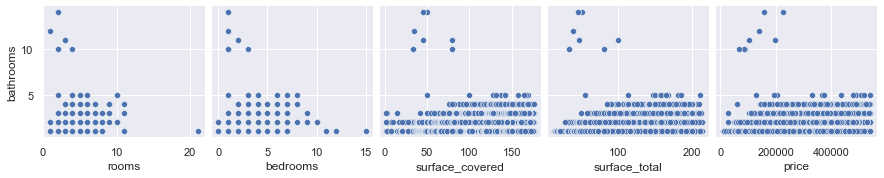

In [27]:
# Gráfica pairplot para evaluar relación entre variables
sns.pairplot(data = cf_outliers, y_vars =['bathrooms'], x_vars=['rooms', 'bedrooms', 'surface_covered', 'surface_total', 'price'])

No se observa una relación clara entre la cantidad de baños y las otras variables diponibles, por lo que decidimos eliminar las instancias de baños con valores faltantes.

In [28]:
cf_outliers.dropna(subset = ['bathrooms'], inplace = True)
cf_outliers.shape

(46626, 9)

In [31]:
for row in len(cf_outliers):
    cf_outliers.iloc(row,'l3')


TypeError: 'int' object is not iterable

In [ ]:
.lat.fillna(data_copy.mean(),inplace = True)
data_copy.isna().sum()

In [ ]:
cf_outliers.groupby(cf_outliers['l3'])

#### Escalado de Datos

In [63]:
from sklearn.preprocessing import StandardScaler

In [64]:
scaler = StandardScaler()
variables = cf_outliers[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']]
scaled_variables = pd.DataFrame(scaler.fit_transform(variables))

In [65]:
scaled_variables.rename(columns= {0: 'scaled_rooms', 1:'scaled_bedrooms', 2:'scaled_bathrooms', 3:'scaled_surface_total', 4:'scaled_surface_covered'}, inplace = True)

In [66]:
scaled_variables

,scaled_rooms,scaled_bedrooms,scaled_bathrooms,scaled_surface_total,scaled_surface_covered
0,3.996138,5.972864,1.020076,1.730448,2.476760
1,-0.687769,-0.915925,1.020076,-0.129931,-0.234180
2,-0.687769,-0.915925,-0.586316,0.268722,-0.498662
3,-0.687769,-0.915925,-0.586316,-0.502007,-0.300300
4,-1.624550,-0.915925,-0.586316,-0.794352,-0.928445
...,...,...,...,...,...
46621,0.249013,0.232207,1.020076,0.188991,0.559266
46622,2.122575,0.232207,1.020076,1.039450,0.989049
46623,1.185794,0.232207,2.626469,2.235408,1.088230
46624,0.249013,0.232207,1.020076,1.836755,2.278399


In [67]:
cf_scaled = pd.concat([cf_outliers.reset_index(drop=True), scaled_variables.reset_index(drop=True)], axis = 1)
cf_scaled.drop(['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered'],axis=1,inplace=True)

In [68]:
cf_scaled.head()

,lat,lon,price,property_type,scaled_rooms,scaled_bedrooms,scaled_bathrooms,scaled_surface_total,scaled_surface_covered
0,-34.605880,-58.384949,153000.0,Departamento,3.996138,5.972864,1.020076,1.730448,2.476760
1,-34.624056,-58.412110,159000.0,PH,-0.687769,-0.915925,1.020076,-0.129931,-0.234180
2,-34.581294,-58.436754,295000.0,PH,-0.687769,-0.915925,-0.586316,0.268722,-0.498662
3,-34.593779,-58.441239,150000.0,PH,-0.687769,-0.915925,-0.586316,-0.502007,-0.300300
4,-34.639598,-58.419612,89000.0,PH,-1.624550,-0.915925,-0.586316,-0.794352,-0.928445


(0.0, 1.0, 0.0, 1.0)

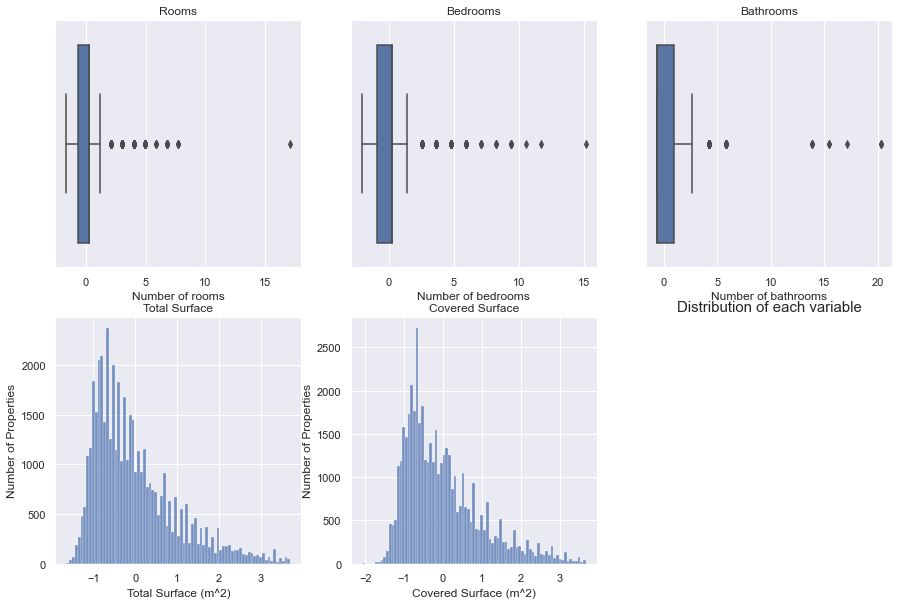

In [69]:
# Grafiquemos las nuevas distribuciones
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
plt.title('Distribution of each variable', fontsize=15)

sns.boxplot(ax=axes[0,0], data = cf_scaled, x='scaled_rooms')
axes[0,0].set(xlabel='Number of rooms', ylabel='',title='Rooms')

sns.boxplot(ax=axes[0,1], data = cf_scaled, x='scaled_bedrooms')
axes[0,1].set(xlabel='Number of bedrooms', ylabel='',title='Bedrooms')

sns.boxplot(ax=axes[0,2], data = cf_scaled, x='scaled_bathrooms')
axes[0,2].set(xlabel='Number of bathrooms', ylabel='',title='Bathrooms')

sns.histplot(ax=axes[1,0], data = cf_scaled, x='scaled_surface_total')
axes[1,0].set(xlabel='Total Surface (m^2)', ylabel='Number of Properties',title='Total Surface')

sns.histplot(ax=axes[1,1], data = cf_scaled, x='scaled_surface_covered')
axes[1,1].set(xlabel='Covered Surface (m^2)', ylabel='Number of Properties',title='Covered Surface')

axes[-1, -1].axis('off')

#### Encoding

De nuestro análisis anterior del dataset sabemos que el tipo de propiedad afecta el valor de las correlaciones entre las variables, como se ve a continuación:

Text(0.5, 1.0, 'Houses')

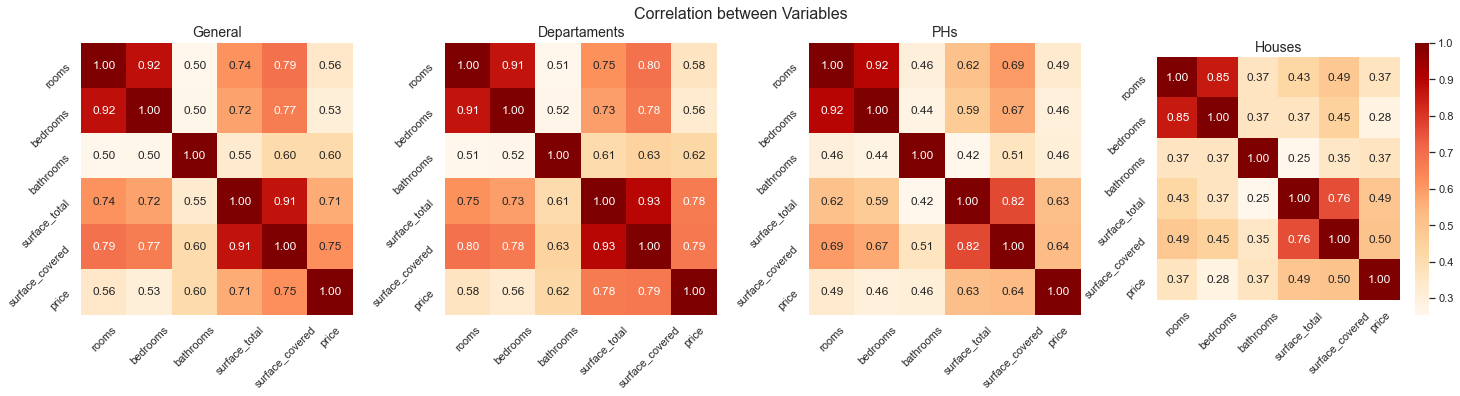

In [70]:
apto = cf_scaled.loc[cf_scaled.property_type == 'Departamento']
apto = apto[['scaled_rooms','scaled_bedrooms','scaled_bathrooms','scaled_surface_total', 'scaled_surface_covered','price']]

PH = cf_scaled.loc[cf_scaled.property_type == 'PH']
PH = PH[['scaled_rooms','scaled_bedrooms','scaled_bathrooms','scaled_surface_total', 'scaled_surface_covered','price']]

casa = cf_scaled.loc[cf_scaled.property_type == 'Casa']
casa = casa[['scaled_rooms','scaled_bedrooms','scaled_bathrooms','scaled_surface_total', 'scaled_surface_covered','price']]

general = cf_scaled[['scaled_rooms','scaled_bedrooms','scaled_bathrooms','scaled_surface_total', 'scaled_surface_covered','price']]

corrs = plt.figure(1)
corrs.set_figheight(5)
corrs.set_figwidth(25)
corrs.suptitle('Correlation between Variables', fontsize = 16)

plt.subplot(141)
sns.heatmap(general.corr(), cbar = False,  square = True, annot=True, fmt= '.2f',
           xticklabels= ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price'], 
           yticklabels= ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price'],
           cmap= 'OrRd')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.title('General', fontsize=14)

plt.subplot(142)
sns.heatmap(apto.corr(), cbar = False,  square = True, annot=True, fmt= '.2f',
           xticklabels= ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price'], 
           yticklabels= ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price'],
           cmap= 'OrRd')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.title('Departaments', fontsize=14)

plt.subplot(143)
sns.heatmap(PH.corr(), cbar = False,  square = True, annot=True, fmt= '.2f',
           xticklabels= ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price'], 
           yticklabels= ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price'],
           cmap= 'OrRd')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.title('PHs', fontsize=14)

plt.subplot(144)
sns.heatmap(casa.corr(), cbar = True,  square = True, annot=True, fmt= '.2f',
           xticklabels= ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price'], 
           yticklabels= ['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price'],
           cmap= 'OrRd')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.title('Houses', fontsize=14)

De forma que aplicaremos One Hot Encoding a la variable de tipo de propiedad:

In [81]:
dummies = pd.get_dummies(cf_scaled.property_type, drop_first= True)
cf_encoding = pd.concat([cf_scaled, dummies], axis = 1)
cf_encoding.shape

(46626, 11)

In [82]:
cf_encoding.head()

,lat,lon,price,property_type,scaled_rooms,scaled_bedrooms,scaled_bathrooms,scaled_surface_total,scaled_surface_covered,Departamento,PH
0,-34.605880,-58.384949,153000.0,Departamento,3.996138,5.972864,1.020076,1.730448,2.476760,1,0
1,-34.624056,-58.412110,159000.0,PH,-0.687769,-0.915925,1.020076,-0.129931,-0.234180,0,1
2,-34.581294,-58.436754,295000.0,PH,-0.687769,-0.915925,-0.586316,0.268722,-0.498662,0,1
3,-34.593779,-58.441239,150000.0,PH,-0.687769,-0.915925,-0.586316,-0.502007,-0.300300,0,1
4,-34.639598,-58.419612,89000.0,PH,-1.624550,-0.915925,-0.586316,-0.794352,-0.928445,0,1


#### Generación de nuevas variables predictoras/reducción de dimensionalidad (SVD/PCA)

Se guarda la variable `price` como target `y` y se elimina las variables `property_type` para así aplicar PCA al dataset de variables numéricas disminuyendo la dimensionalidad de los atributos e identificando las variables más y menos importantes del dataset.

In [98]:
y =  cf_encoding['price']
cf_PCA = cf_encoding.drop(['property_type','price','lat','lon'],axis=1)

In [99]:
cf_PCA.describe()

,scaled_rooms,scaled_bedrooms,scaled_bathrooms,scaled_surface_total,scaled_surface_covered,Departamento,PH
count,4.662600e+04,4.662600e+04,4.662600e+04,4.662600e+04,4.662600e+04,46626.000000,46626.000000
mean,-8.351079e-17,-2.133487e-18,-8.290122e-17,-1.243518e-16,-1.706790e-16,0.869601,0.114636
std,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,1.000011e+00,0.336746,0.318585
min,-1.624550e+00,-2.064056e+00,-5.863165e-01,-1.644811e+00,-2.085554e+00,0.000000,0.000000
25%,-6.877686e-01,-9.159245e-01,-5.863165e-01,-7.411984e-01,-7.631439e-01,1.000000,0.000000
50%,2.490127e-01,2.322069e-01,-5.863165e-01,-2.628153e-01,-2.341799e-01,1.000000,0.000000
75%,2.490127e-01,2.322069e-01,1.020076e+00,4.813363e-01,4.931455e-01,1.000000,0.000000
max,1.711108e+01,1.515792e+01,2.029679e+01,3.697134e+00,3.666929e+00,1.000000,1.000000


In [100]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
X_nuevo = pca.fit_transform(cf_PCA) 

In [101]:
pca.components_

array([[ 0.46533964,  0.4608018 ,  0.35349929,  0.46208406,  0.47923052,
        -0.04454231,  0.03148621],
       [-0.31611541, -0.30569448,  0.88682211, -0.03824208, -0.00092324,
         0.10198358, -0.09112911],
       [ 0.39155724,  0.46443509,  0.23885357, -0.61255317, -0.38724218,
         0.17279631, -0.13746087],
       [ 0.05159303,  0.03929164,  0.17462713,  0.00300855, -0.32381458,
        -0.66212541,  0.64963428],
       [ 0.71843259, -0.69054198,  0.01434388, -0.07664115,  0.03006858,
         0.00466463,  0.00095033]])

In [103]:
X_nuevo

array([[ 6.94959796, -2.22920351,  2.60156625, -0.33862741, -1.29657742],
       [-0.48716386,  1.23785107, -0.55273213,  1.33304846,  0.15270248],
       [-0.99755936, -0.20173463, -1.07820211,  1.1393712 ,  0.09115478],
       ...,
       [ 3.13229489,  1.82063249, -0.55293158,  0.0224839 ,  0.59113481],
       [ 2.59069749,  0.51321274, -1.83037255,  0.61879904, -0.04229571],
       [ 2.70122798,  0.70497333, -1.67722064, -0.81063998, -0.02968348]])

## PARTE B - Modelos Avanzados

1. Elige dos de los modelos avanzados vistos Compara con el desempeño obtenido en el proyecto 01 (en el caso de regresión, considera una regresión lineal con atributos polinómicos y regularización). Entrénalos y evalúalos con sus argumentos por defecto. No te olvides de hacer un train/test split y usar Validación Cruzada.
2. Optimiza sus hiperparámetros mediante Validación Cruzada y Grid Search o Random Search.
3. Compara el desempeño de los nuevos modelos entre sí y con el modelo de la Parte A 
¿Cuál elegirías? Justifica

##### Train/Test Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_nuevo, y, test_size=0.3, random_state=42)

##### Métricas de evaluación
Se seleccionan las métricas de evaluación para los modelos:

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#Dataframe para almacenar los resultados de error
errores = pd.DataFrame(columns = ['Modelo','RMSE Train', 'RMSE Test', 'R2 Train', 'R2 Test'])

#Función de cálculo del RMSE para datos de entrenamiento y test
def error(modelo, y_train, y_train_pred, y_test, y_test_pred):
    global errores
    
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_train, y_train_pred)
    errores = errores.append({'Modelo':modelo,'RMSE Train':round(rmse_train,2),'RMSE Test':round(rmse_test,2),
                              'R2 Train':round(r2_train,4),'R2 Test':round(r2_test,4)},  ignore_index=True)
    return errores

#### B.1 Modelo de regresión lineal avanzada

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
import sklearn as sk

X = x.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

#poly = PolynomialFeatures(7, include_bias=False)
poly = sk.preprocessing.PolynomialFeatures(7, include_bias=False)
#X_train_new = poly.fit_transform(X_train)
poly_train = poly.fit(X_train)
X_train_new = poly_train.transform(X_train)
X_test_new = poly.fit_transform(X_test)
print(X_train_new.shape, X_test_new.shape)

## PARTE C - Interpretación de modelos

De acuerdo a lo que el modelo permite, responde algunas o todas las siguientes preguntas:

1. ¿Qué variables fueron relevantes para el modelo para hacer una predicción? ¿Cuáles no? Si usaste una regresión lineal con regularización, presta atención a los parámetros (pendientes) obtenidas. Si usaste un modelo de ensamble en árboles, además de ver la importancia de cada atributo, también elige algunos árboles al azar y observa qué atributos considera importantes. ¿En qué se diferencian esos árboles? ¿Por qué? Finalmente, responde, ¿coincide con lo que esperabas a partir de tu experiencia con este dataset?

2. ¿Cómo es la distribución de errores (regresión) o qué clases se confunden entre sí (clasificación)? ¿Dónde falla? ¿A qué se debe?

### DESAFÍO OPCIONAL

Aplica una técnica de Clustering sobre el dataset. Puedes combinar con técnicas de reducción de dimensionalidad para facilitar la visualización. ¿Qué clusters encuentras? ¿A qué pueden corresponder? Te dejamos preguntas que pueden servir como disparadoras: ¿qué barrios se parecen más entre sí?¿qué tipos de propiedades se parecen más entre sí?